# [Roboflow dataset](https://universe.roboflow.com/mrinmoy-bhadra-lojma/golfballdetector)

# Imports

In [2]:
# Model Building
import torch
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Data Extraction
from bs4 import BeautifulSoup # Parse through xml files and extract bounding boxes / labels
from PIL import Image # Image editing

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Access Files
import os

# Functions to parse xml data and retrieve bounding boxes + labels


Following code snippet taken from Pytorch FasterRCNN by Daniel and tweaked to match this project

*   def generate_box(obj): Input "object" from xml; Output bounding box
*   def generate_label(obj): Input "object" from xml; Output label


Fine-tuning pretrained fasterrcnn_resnet50_fpn requires the following input tensors and targets:

*   Bounding-boxes of type FloatTensor[N, 4]
*   Labels of type Int64Tensor[N]











In [3]:
# Get Ground Truth Box
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

# Get Ground Truth Label
def generate_label(obj):
    if obj.find('name'): # Dataset is poorly labeled, all objects will be considered of class "Golfball": 1
        return 1
    return 0 # Is not ball

# Use BeautifulSoup to read xml data, all data stored in objects[]
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        # Bounding boxes for objects
        # In pytorch, the input should be [xmin, ymin, xmax, ymax], WE ARE USING THIS
        # In coco format, bounding box = [xmin, ymin, width, height]
        boxes = []
        labels = []
        for obj in objects:
            boxes.append(generate_box(obj))
            labels.append(generate_label(obj))

        # Convert boxes and labels to tensor objects for fasterrcnn_resnet50_fpn
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        return target

# CREATE DATALOADER

## Create Dataset() class for torch.utils.data.DataLoader(), this is a Map-style Dataset

*   implements \__getitem__() and \__len__()



In [4]:
class Dataset():
  def __init__(self, imgs, labels, img_indices, label_indices, select_set):
    self.imgs = imgs
    self.labels = labels
    self.img_indices = img_indices
    self.label_indices = label_indices
    assert select_set == "train" or select_set == "test" or select_set == "valid"
    self.select_set = select_set

  def __getitem__(self, idx):
    # Generate file paths from idx
    img_file = self.imgs[self.img_indices[idx]]
    label_file = self.labels[self.label_indices[idx]]

    img_path = os.path.join("archive/" + self.select_set, img_file)
    label_path = os.path.join("archive/" + self.select_set, label_file)

    # Load Image
    img = Image.open(img_path).convert("RGB")
    data_transform = transforms.Compose([transforms.ToTensor(), ])
    img = data_transform(img)

    # Generate Label
    target = generate_target(label_path)

    return img, target

  def __len__(self):
    return len(self.img_indices)

In [ ]:
# Extract all files from their respective folders and sort
train_imgs = list(sorted(os.listdir("archive/train/")))
train_labels = list(sorted(os.listdir("archive/train/")))

test_imgs = list(sorted(os.listdir("archive/test/")))
test_labels = list(sorted(os.listdir("archive/test/")))

valid_imgs = list(sorted(os.listdir("archive/valid/")))
valid_labels = list(sorted(os.listdir("archive/valid/")))

## Create collate function for torch.utils.data.DataLoader()

In [48]:
def collate_fn(batch):
  return tuple(zip(*batch))

## Train/Valid Split

In [49]:
# Get total numbers of files to assist in splitting images from labels in the shared folders
total_train = len(list(sorted(os.listdir("archive/train/"))))
total_test = len(list(sorted(os.listdir("archive/test/"))))
total_valid = len(list(sorted(os.listdir("archive/valid/"))))

In [50]:
# Split images and labels from within the folders
train_img_indices, train_label_indices = [], []
for file in range(total_train):
    if file % 2 == 0:
        train_img_indices.append(file)
    else:
        train_label_indices.append(file)

test_img_indices, test_label_indices = [], []
for file in range(total_test):
    if file % 2 == 0:
        test_img_indices.append(file)
    else:
        test_label_indices.append(file)

valid_img_indices, valid_label_indices = [], []
for file in range(total_valid):
    if file % 2 == 0:
        valid_img_indices.append(file)
    else:
        valid_label_indices.append(file)

## Create train and validation DataLoader() objects

In [51]:
# Batch sizes used here for validation and testing are low due to personal hardware limitations
train_dl = torch.utils.data.DataLoader(dataset=Dataset(train_imgs, train_labels, train_img_indices, train_label_indices, "train"),
                                          batch_size=32,
                                          collate_fn=collate_fn)

valid_dl = torch.utils.data.DataLoader(dataset=Dataset(valid_imgs, valid_labels, valid_img_indices, valid_label_indices, "valid"),
                                          batch_size=4,
                                          collate_fn=collate_fn)

test_dl = torch.utils.data.DataLoader(dataset=Dataset(test_imgs, test_labels, test_img_indices, test_label_indices, "test"),
                                          batch_size=4,
                                          collate_fn=collate_fn)

# Make instance of pretrained Faster R-CNN

In [35]:
def get_model(num_classes):
  model = models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [36]:
# Instantiate pretrained model
model = get_model(3)

# Fine-tune Faster R-CNN model on our dataset

## Create optimizer

In [37]:
# For this project I did not experiment with various optimizer settings
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.0005)

## Set Device type

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Load model weights
* NOTE: These are taken from a local file and made for personal use, I may upload to google drive provide a download link in future update

In [ ]:
model.load_state_dict(torch.load('ModelWeights.pt')) # These were created from running 10 epochs on the dataset

## Fine-tune

In [ ]:
model.to(device)
num_epochs = 10
len_dataloader = len(train_dl)

for epochs in range(num_epochs):
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in train_dl:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    loss_dict = model([imgs[0]], [annotations[0]])
    loss = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print(f'Iteration: {i}/{len_dataloader}, Loss: {loss}') # Show each iteration
    epoch_loss += loss

  print(epoch_loss)

## Save model weights

In [79]:
torch.save(model.state_dict(),'NewModelWeights.pt')

## Grab first batch of images and labels from test set

In [80]:
# Prepare test set for experimentation
for imgs, annotations in test_dl:
      imgs = list(img.to(device) for img in imgs)
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
      break # Take only first batch

## Enter evaluation mode and generate predictions of test dataset

In [81]:
model.eval()
# Use with torch.no_grad() to prevent memory buildup exceeding colab's limits when running on cpu
# If still exceeding reduce validation batch_size
with torch.no_grad():
  preds = model(imgs) # Generate predictions

In [82]:
def plot_image(img_tensor, annotation):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    for box in annotation["boxes"]:
        box = box.cpu() # Use if running cuda
        xmin, ymin, xmax, ymax = box.detach().numpy()

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin.item(),ymin.item()),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


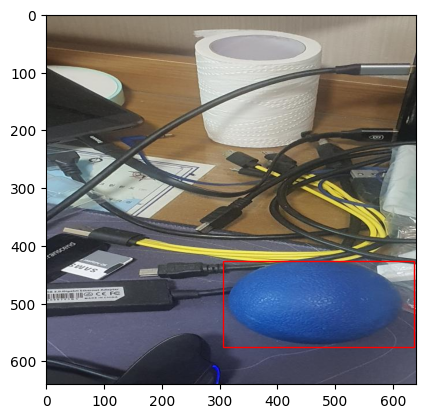

Target


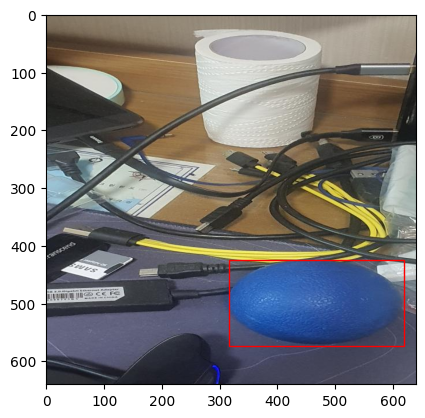

In [84]:
IMG_NUM = 2 # [0, batch_size - 1]
print("Prediction")
plot_image(imgs[IMG_NUM], preds[IMG_NUM])
print("Target")
plot_image(imgs[IMG_NUM], annotations[IMG_NUM])